In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy import signal
import pandas as pd

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data

torch.cuda.set_device(2)
torch.manual_seed(0)

# Load the datasets

In [2]:
X_train = np.load("./numpy_ds/x_train.npy")
X_val = np.load("./numpy_ds/x_val.npy")
X_test = np.load("./numpy_ds/x_test.npy")

y_train = np.load("./numpy_ds/y_train.npy")
y_val = np.load("./numpy_ds/y_val.npy")
y_test = np.load("./numpy_ds/y_test.npy")

In [13]:
class LSTMSpeechMode(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(LSTMSpeechMode, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=self.hidden_size, 
                             batch_first=True, num_layers=self.n_layers)
        self.fc = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, x):
        batch_size = x.size(0)
        hidden = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))
        
        out, hidden = self.lstm(x)
        out = self.fc(hidden[-1])
        return out

In [30]:
INPUT_SIZE = 13
HIDDEN_SIZE = 100
OUTPUT_SIZE = 3
N_LAYERS = 2

In [40]:
random.seed(0)

def train_lstm(model, x_tr, y_tr, x_v, y_v, criterion, optimizer, epoch_range, batch_size):
    losses = []
    v_losses = []
   
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, x_tr.shape[0]), batch_size)
        x = np.zeros((batch_size, 299, 13))
        y = np.zeros((batch_size, 3))
        for i, feats in enumerate(selected):
            x[i, :, :] = x_tr[feats, :, :]
            y[i, :] = y_tr[feats, :]
        x = torch.from_numpy(x).float().cuda()
        y = torch.from_numpy(y).long().cuda()
        hidden = torch.randn(N_LAYERS, batch_size, 8)
        #---------FORWARD------------#
        out = model.forward(x)
        out = torch.tensor(out).float().cuda()
        out = out.view(N_LAYERS, batch_size, OUTPUT_SIZE)[-1]
        loss = criterion(out, torch.max(y,1)[1])
        #---------BACKWARD------------#
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        v = random.sample(range(0, x_v.shape[0]), 8)
        xv = np.zeros((8, 299, 13))
        yv = np.zeros((8, 3))
        for i, feats in enumerate(v):
            xv[i, :, :] = x_v[feats, :, :]
            yv[i, :] = y_v[feats, :]
        xv = torch.from_numpy(xv).float().cuda()
        yv = torch.from_numpy(yv).long().cuda()
        hidden_v = torch.randn(N_LAYERS, 8, 8)
        v_out = model.forward(xv)
        v_out = torch.tensor(v_out).float().cuda()
        v_out = v_out.view(N_LAYERS, 8, OUTPUT_SIZE)[-1]
        vloss = criterion(v_out, torch.max(yv, 1)[1])
        
        losses.append(loss.data[0])
        v_losses.append(vloss.data[0])
        if num_epoch%100 == 0:
            print('epoch [{}/{}], loss:{:.8f}, val:{:.8f}'.format(num_epoch, epoch_range, 
                                                              loss.data[0], vloss.data[0]))
    return losses, v_losses

In [41]:
def init_weights(layer):
    if type(layer) == nn.Linear or type(layer) == nn.Conv2d:
        nn.init.xavier_normal_(layer.weight)

In [42]:
epoch_range = 5000
batch_size = 48
learning_rate = 0.0001

lstm_1 = LSTMSpeechMode(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, N_LAYERS).cuda()
lstm_1.apply(init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    lstm_1.parameters(), lr=learning_rate)

losses_1, vloss = train_lstm(lstm_1, X_train, y_train, X_val, y_val,
                                 criterion, optimizer, epoch_range, batch_size)

/disk/scratch/s1769454/anaconda3/envs/dissertation/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/disk/scratch/s1769454/anaconda3/envs/dissertation/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/disk/scratch/s1769454/anaconda3/envs/dissertation/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [0/5000], loss:1.12631190, val:1.11313319
epoch [100/5000], loss:0.81044751, val:0.80006075
epoch [200/5000], loss:0.47232318, val:0.29819942
epoch [300/5000], loss:0.18818319, val:0.18648283
epoch [400/5000], loss:0.09496715, val:0.08856271
epoch [500/5000], loss:0.03167209, val:0.42817536
epoch [600/5000], loss:0.01111604, val:0.01589537
epoch [700/5000], loss:0.08362126, val:0.00660405
epoch [800/5000], loss:0.00963647, val:0.68223816
epoch [900/5000], loss:0.00205980, val:0.19446892
epoch [1000/5000], loss:0.00174131, val:0.00393313
epoch [1100/5000], loss:0.00113612, val:0.00027478
epoch [1200/5000], loss:0.00173140, val:1.36172903
epoch [1300/5000], loss:0.00139517, val:0.00002867
epoch [1400/5000], loss:0.00068804, val:0.07914174
epoch [1500/5000], loss:0.00076963, val:0.04538459
epoch [1600/5000], loss:0.00048845, val:0.00016838
epoch [1700/5000], loss:0.00048875, val:0.00004035
epoch [1800/5000], loss:0.00020272, val:0.00423747
epoch [1900/5000], loss:0.00013752, val:1.2

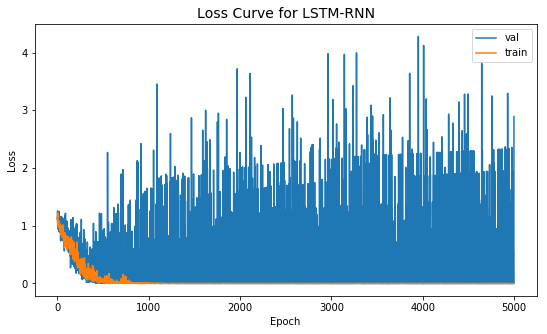

In [47]:
fig = plt.figure(figsize=(9, 5))
plt.title("Loss Curve for LSTM-RNN", fontsize=14)
plt.plot(vloss, label="val")
plt.plot(losses_1, label="train")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
fig.savefig("./images/lstm_performance.pdf", bbox_inches='tight')

In [46]:
total = y_test.shape[0]
correct = 0

for i in range(X_test.shape[0]):
    data = X_test[i, :, :]
    data = torch.from_numpy(data).float().cuda()
    data = data.view(1, 299, 13)
    true_out = y_test[i, :]
    mdl_out = lstm_1.forward(data)
    mdl_out = mdl_out.view(N_LAYERS, 3)[-1]
    out = (mdl_out.data).cpu().numpy()
    if np.argmax(out) == np.argmax(true_out):
        correct += 1
print("Accuracy = ", correct*100/total)

Accuracy =  89.58333333333333


In [48]:
torch.save(lstm_1, 'models/lstm_speechmode.pt')

/disk/scratch/s1769454/anaconda3/envs/dissertation/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type LSTMSpeechMode. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
